In [32]:
"""
This is a jupyter notebook for the QA and for data description. 

Before coming here, run the python files in the following order:
    1. n1_geturls.py
    2. n2_downloadfiles.py
    3. n3_scrapepdfs.py
    4. n4_cleandata.py
    
"""

'\nThis is a jupyter notebook for the QA and for data description. \n\nBefore coming here, run the python files in the following order:\n    1. n1_geturls.py\n    2. n2_downloadfiles.py\n    3. n3_scrapepdfs.py\n    4. n4_cleandata.py\n    \n'

In [33]:
#import packages
import pandas as pd
import numpy as np
import os
import datetime
import glob
import re
import datetime
import calendar
import matplotlib.pyplot as plt

#define directories
uncleaned_dir = "Halt Project/data/uncleaned/"
data_dir="Halt Project/data/"

# QA

In [34]:
#import uncleaned dataframes from files so that QA can be done.

dfs = {}

# iterate over all files in the folder to create a dictionary of dataframes
for filename in os.listdir(uncleaned_dir):
    if filename.endswith('.csv'):  # check if the file is a csv
        filepath = os.path.join(uncleaned_dir, filename)  # get the full path to the file
        dataframe = pd.read_csv(filepath)  # import the csv as a dataframe
        name = os.path.splitext(filename)[0]  # remove the .csv extension from the filename
        dataframe.columns = [f'c{i+1}' for i in range(len(dataframe.columns))] # name columns c1 to c13
        dfs[name] = dataframe  # add the dataframe to the dictionary with the modified filename as the key

# create dataframes with custom names based on the dictionary keys
for name, dataframe in dfs.items():
    globals()[f"{name}"] = dataframe
    
#import final for QA as dataframe
final=pd.read_csv('Halt Project/data/final.csv')

In [35]:
#Check that the number of records per each month matches the number of records in the pdfs. 
#create a new column in the final dataframe which labels year_month. 
#group the final dataframe by year_month
final['date'] = pd.to_datetime(final['date'])
final['year_month'] = final['date'].dt.strftime('%Y-%m')
numbymonth=final.groupby(['year_month']).size().reset_index()
numbymonth.columns=['year_month','numrows']
numbymonth['year_month_d']=pd.to_datetime(numbymonth['year_month'])
numbymonth['ym']=numbymonth['year_month_d'].dt.strftime('%B_%Y').str.lower()
                    
#create a dictioanry that maps the file to the number of pages in each report. 
import PyPDF2

pdf_page_counts={}
for filename in os.listdir('downloads/halt'):
    if filename.endswith('.pdf'):
        file_date=re.search(r'(\w+-\d{4})\.pdf',filename).group(1)
        month,year=file_date.split('-')
        file_date=f"{month.lower()}_{year}"
        with open(os.path.join('downloads/halt',filename),'rb') as f:
            pdf_reader=PyPDF2.PdfFileReader(f)
            num_pages=pdf_reader.getNumPages()
            pdf_page_counts[file_date]=num_pages
            
#create a dictionary that shows the scraped dataframes and lengths
df_lengths={key:len(dfs[key]) for key in dfs}

#map the scraped dataframe lengths
numbymonth['dflen']=numbymonth['ym'].map(df_lengths)

#map the pdf page counts
numbymonth['pgcts']=numbymonth['ym'].map(pdf_page_counts)

#calculate the expected number of rows based on the page count and dataframe length. 
#the expected number of rows will be the (dataframe length)-2*the number of pages
#because each month except for april has two extra rows containing column information
#april for some reason has six extra imported rows, so you need to modify the formula
numbymonth['expected_rows'] = numbymonth['dflen'] - (numbymonth['pgcts'] * np.where(numbymonth['ym'] == 'april_2022', 6, 2))


#compare the expected rows and the actual number of rows:
numbymonth['numrows']=numbymonth['numrows'].astype(str)
numbymonth['expected_rows']=numbymonth['expected_rows'].astype(str).str.split('.').str[0]

for idx, row in numbymonth.iterrows():
    if row['expected_rows']==' ':
        print(f"Issue found with {row['ym']}")
    elif row['expected_rows']==(row['numrows']):
        print('Perfect Match!')
    else:
        print(f"Issue found with {row['ym']}")

Perfect Match!
Perfect Match!
Perfect Match!
Perfect Match!
Perfect Match!
Perfect Match!
Perfect Match!
Perfect Match!
Perfect Match!
Perfect Match!


In [36]:
numbymonth

,year_month,numrows,year_month_d,ym,dflen,pgcts,expected_rows
0,2022-04,864,2022-04-01,april_2022,990,21,864
1,2022-05,1068,2022-05-01,may_2022,1116,24,1068
2,2022-06,691,2022-06-01,june_2022,721,15,691
3,2022-07,774,2022-07-01,july_2022,808,17,774
4,2022-08,755,2022-08-01,august_2022,789,17,755
5,2022-09,682,2022-09-01,september_2022,710,14,682
6,2022-10,657,2022-10-01,october_2022,687,15,657
7,2022-11,653,2022-11-01,november_2022,681,14,653
8,2022-12,647,2022-12-01,december_2022,675,14,647
9,2023-01,654,2023-01-01,january_2023,684,15,654


In [37]:
#Check that the total number of expected rows equals the total number of rows in the final dataframe
#this ensures there are no extra rows. 
expectedtotrows=numbymonth['numrows'].astype(int).sum()
actualtotrows=len(final)
if actualtotrows==expectedtotrows:
    print("Actual Total Rows = Expected Total Rows")
else:
    print('Actual Total Rows != Expected Total Rows')

Actual Total Rows = Expected Total Rows


In [38]:
#Let's check to make sure that all of the facilities are listed by cross-referencing another source.
#dataframe 'sec_level' (Security Level) was created by gathering information from 
#this map: https://doccs.ny.gov/system/files/documents/2022/09/facility-map-11-1-22.pdf

sec_level = [
            ['EDGECOMBE', 'MINIMUM','BRONX'], ['LAKEVIEW', 'MINIMUM','WESTERN'], ['QUEENSBORO', 'MINIMUM','QUEENS-LI'],
            ['ADIRONDACK', 'MEDIUM','CENTRAL'], ['ALBION', 'MEDIUM','WESTERN'], ['ALTONA', 'MEDIUM','CENTRAL'],
            ['BARE HILL', 'MEDIUM','CENTRAL'], ['CAPE VINCENT', 'MEDIUM','CENTRAL'], ['CAYUGA', 'MEDIUM','CENTRAL'],
            ['COLLINS', 'MEDIUM','WESTERN'], ['FISHKILL', 'MEDIUM','HUDSON VALLEY'], ['FRANKLIN', 'MEDIUM','CENTRAL'],
            ['GOUVERNEUR', 'MEDIUM','CENTRAL'], ['GREENE', 'MEDIUM','HUDSON VALLEY'], ['GROVELAND', 'MEDIUM','WESTERN'],
            ['HALE CREEK', 'MEDIUM','HUDSON VALLEY'], ['HUDSON', 'MEDIUM','HUDSON VALLEY'], ['MARCY', 'MEDIUM','CENTRAL'],
            ['MID-STATE', 'MEDIUM','CENTRAL'], ['MOHAWK', 'MEDIUM','CENTRAL'], ['ORLEANS', 'MEDIUM','WESTERN'],
            ['OTISVILLE', 'MEDIUM','HUDSON VALLEY'], ['RIVERVIEW', 'MEDIUM','CENTRAL'], ['TACONIC', 'MEDIUM','HUDSON VALLEY'],
            ['ULSTER', 'MEDIUM','HUDSON VALLEY'], ['WALLKILL', 'MEDIUM','HUDSON VALLEY'], ['WASHINGTON', 'MEDIUM','HUDSON VALLEY'],
            ['WOODBOURNE', 'MEDIUM','HUDSON VALLEY'], ['WYOMING', 'MEDIUM','WESTERN'],
            ['ATTICA', 'MAXIMUM','WESTERN'], ['AUBURN', 'MAXIMUM','CENTRAL'], ['BEDFORD HILLS', 'MAXIMUM','HUDSON VALLEY'],
            ['CLINTON', 'MAXIMUM','CENTRAL'], ['COXSACKIE', 'MAXIMUM','HUDSON VALLEY'], ['EASTERN', 'MAXIMUM','HUDSON VALLEY'],
            ['ELMIRA', 'MAXIMUM','CENTRAL'], ['FIVE POINTS', 'MAXIMUM','CENTRAL'], ['GREAT MEADOW', 'MAXIMUM','HUDSON VALLEY'],
            ['GREEN HAVEN', 'MAXIMUM','HUDSON VALLEY'], ['SHAWANGUNK', 'MAXIMUM','HUDSON VALLEY'], ['SING SING', 'MAXIMUM','HUDSON VALLEY'],
            ['SULLIVAN', 'MAXIMUM','HUDSON VALLEY'], ['UPSTATE', 'MAXIMUM','CENTRAL'], ['WENDE', 'MAXIMUM','WESTERN']
            ]

sec = pd.DataFrame(sec_level, columns=['facility','security_level','borough'])

# convert 'facility' column to lowercase for case-insensitivity
final['facility'] = final['facility'].str.lower()
sec['facility'] = sec['facility'].str.lower()

# find values in 'facility' column of alldata that are not in 'facility' column of sec
not_in_sec = final.loc[~final['facility'].isin(sec['facility'])]
print('there are',len(sec_level),'facilities in the sec_level dataframe.')
print('there are',final['facility'].nunique(),'facilities in the final dataframe.')
not_in_sec

there are 44 facilities in the sec_level dataframe.
there are 45 facilities in the final dataframe.


,time,facility,tier,date,g1,g1_label,g2,g2_label,g3,g3_label,tot_infractions,tot_g_infractions,orig_shu_days,year_month
1082,1215,uncoded,3,2022-12-15,100.11,ASSAULT ON STAFF,104.11,VIOLENT CONDUCT,NaN,NaN,3,2.0,90,2022-12
2197,830,uncoded,3,2023-01-04,118.22,UNHYGIENIC ACT,104.11,VIOLENT CONDUCT,104.13,CREATE DISTURB,3,3.0,45,2023-01
2264,830,uncoded,3,2023-01-06,113.10,WEAPON,114.10,SMUGGLING,NaN,NaN,2,2.0,180,2023-01
2334,950,uncoded,3,2023-01-09,102.10,THREATS,107.10,INTERFERENCE,104.13,CREATE DISTURB,3,3.0,60,2023-01
2422,1715,uncoded,3,2023-01-11,111.11,POSSESS EMP PROP,102.10,THREATS,106.10,DIRECT ORDER,5,5.0,60,2023-01
2556,1223,uncoded,3,2023-01-16,118.10,ARSON,104.11,VIOLENT CONDUCT,115.10,SEARCH/FRISK,7,7.0,90,2023-01
2634,830,uncoded,3,2023-01-19,100.11,ASSAULT ON STAFF,102.10,THREATS,104.11,VIOLENT CONDUCT,11,10.0,180,2023-01


In [39]:
final

,time,facility,tier,date,g1,g1_label,g2,g2_label,g3,g3_label,tot_infractions,tot_g_infractions,orig_shu_days,year_month
0,1305,attica,3,2022-09-01,118.22,UNHYGIENIC ACT,102.10,THREATS,107.10,INTERFERENCE,3,3.0,89,2022-09
1,1100,auburn,3,2022-09-01,101.20,LEWD CONDUCT,112.20,DELAY COUNT,NaN,NaN,2,2.0,60,2022-09
2,1250,auburn,3,2022-09-01,113.10,WEAPON,115.10,SEARCH/FRISK,113.23,CONTRABAND,5,3.0,90,2022-09
3,1215,auburn,3,2022-09-01,100.13,FIGHTING,118.10,ARSON,104.11,VIOLENT CONDUCT,7,7.0,60,2022-09
4,1920,cayuga,3,2022-09-01,118.10,ARSON,118.31,TAMPER W/ ELEC,NaN,NaN,2,2.0,30,2022-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7440,2210,ulster,3,2022-04-27,100.11,ASSAULT ON STAFF,102.10,THREATS,104.11,VIOLENT CONDUCT,6,6.0,45,2022-04
7441,1145,wallkill,3,2022-04-27,100.10,ASSAULT ON INMATE,113.10,WEAPON,104.11,VIOLENT CONDUCT,4,4.0,177,2022-04
7442,820,clinton,3,2022-04-28,104.11,VIOLENT CONDUCT,115.10,SEARCH/FRISK,106.10,DIRECT ORDER,5,3.0,45,2022-04
7443,800,collins,3,2022-04-28,106.10,DIRECT ORDER,107.10,INTERFERENCE,109.12,MOVEMENT VIO,3,3.0,59,2022-04


# Part 5: Describe the Data

In [40]:
#Let's start by listing the uncoded facilities discovered during the QA.
uncoded=final[final['facility']=='uncoded']
print('There are',len(uncoded),'records which do not have a Facility coded for them.')

#download the csv
uncoded.to_csv(data_dir+'uncodedfacilityrecords.csv')
uncoded

There are 7 records which do not have a Facility coded for them.


,time,facility,tier,date,g1,g1_label,g2,g2_label,g3,g3_label,tot_infractions,tot_g_infractions,orig_shu_days,year_month
1082,1215,uncoded,3,2022-12-15,100.11,ASSAULT ON STAFF,104.11,VIOLENT CONDUCT,NaN,NaN,3,2.0,90,2022-12
2197,830,uncoded,3,2023-01-04,118.22,UNHYGIENIC ACT,104.11,VIOLENT CONDUCT,104.13,CREATE DISTURB,3,3.0,45,2023-01
2264,830,uncoded,3,2023-01-06,113.10,WEAPON,114.10,SMUGGLING,NaN,NaN,2,2.0,180,2023-01
2334,950,uncoded,3,2023-01-09,102.10,THREATS,107.10,INTERFERENCE,104.13,CREATE DISTURB,3,3.0,60,2023-01
2422,1715,uncoded,3,2023-01-11,111.11,POSSESS EMP PROP,102.10,THREATS,106.10,DIRECT ORDER,5,5.0,60,2023-01
2556,1223,uncoded,3,2023-01-16,118.10,ARSON,104.11,VIOLENT CONDUCT,115.10,SEARCH/FRISK,7,7.0,90,2023-01
2634,830,uncoded,3,2023-01-19,100.11,ASSAULT ON STAFF,102.10,THREATS,104.11,VIOLENT CONDUCT,11,10.0,180,2023-01


In [41]:
#Let's look at descriptive statistics for each of the columns 
stats=final.describe(include='all',datetime_is_numeric=True)
stats.to_csv(data_dir+'stats.csv')
stats

,time,facility,tier,date,g1,g1_label,g2,g2_label,g3,g3_label,tot_infractions,tot_g_infractions,orig_shu_days,year_month
count,7445.000000,7445,7445.0,7445,7445.000000,7445,6922.000000,6922,5769.000000,5769,7445.000000,7445.000000,7445.000000,7445
unique,NaN,45,NaN,NaN,NaN,61,NaN,98,NaN,105,NaN,NaN,NaN,10
top,NaN,upstate,NaN,NaN,NaN,FIGHTING,NaN,VIOLENT CONDUCT,NaN,DIRECT ORDER,NaN,NaN,NaN,2022-05
freq,NaN,584,NaN,NaN,NaN,1361,NaN,2198,NaN,1624,NaN,NaN,NaN,1068
mean,1332.874681,NaN,3.0,2022-08-16 00:18:22.484889344,104.534109,NaN,107.360030,NaN,107.643923,NaN,4.198925,3.789657,100.815581,NaN
min,0.000000,NaN,3.0,2022-04-01 00:00:00,100.100000,NaN,100.100000,NaN,100.110000,NaN,1.000000,1.000000,1.000000,NaN
25%,940.000000,NaN,3.0,2022-05-27 00:00:00,100.130000,NaN,104.110000,NaN,104.130000,NaN,3.000000,3.000000,34.000000,NaN
50%,1258.000000,NaN,3.0,2022-08-08 00:00:00,102.100000,NaN,104.130000,NaN,106.100000,NaN,4.000000,4.000000,67.000000,NaN
75%,1715.000000,NaN,3.0,2022-11-03 00:00:00,106.100000,NaN,113.100000,NaN,107.100000,NaN,5.000000,5.000000,120.000000,NaN
max,2359.000000,NaN,3.0,2023-01-25 00:00:00,118.220000,NaN,181.100000,NaN,181.100000,NaN,21.000000,19.000000,1825.000000,NaN


In [42]:
#Let's look at how many unique guilty values there are. 
#Create a dictionary of all guilties by concatenating all guilty values into a single dataframe
g1df=final[['g1','g1_label']]
g2df=final[['g2','g2_label']]
g3df=final[['g3','g3_label']]
g1df.columns=['g','g_label']
g2df.columns=['g','g_label']
g3df.columns=['g','g_label']
gdf=pd.concat([g1df,g2df,g3df],axis=0)

#drop nas
gdf.dropna(how='all', inplace=True)

#format column
gdf['g']=gdf['g'].astype(str) 
gdf['g'] = gdf['g'].str.strip() #strip out white spaces
gdf['g_label'] = gdf['g_label'].str.strip() #strip out white spaces
gdf['g'] = gdf['g'].replace(r'^\s*$', np.nan, regex=True)
gdf['g'] = pd.to_numeric(gdf['g'], errors='coerce')
# Format values with two decimal places
gdf['g'] = gdf['g'].map(lambda x: f"{x:.2f}" if not np.isnan(x) else '')

#create dictionary
gdict=dict(zip(gdf['g'], gdf['g_label']))

#remove any empty dictionary entries
gdict = {k: v for k, v in gdict.items() if v != ''}

#print the number of guilty codes
print('there are',len(gdict),'guilty codes')

#download the guilty codes as a csv
gdict_df = pd.DataFrame.from_dict(gdict, orient='index')
gdict_df.to_csv(data_dir+'unique_guilty_values.csv')

there are 81 guilty codes


In [44]:
#Create a dictionary of all guilties
g1df=final[['g1','g1_label']]
g2df=final[['g2','g2_label']]
g3df=final[['g3','g3_label']]
g1df.columns=['g','g_label']
g2df.columns=['g','g_label']
g3df.columns=['g','g_label']
gdf=pd.concat([g1df,g2df,g3df],axis=0)
gdf.dropna(how='all', inplace=True)
gdf = gdf[gdf['g'] != 'nan']
gdf['g']=gdf['g'].astype(str)
gdf['g'] = gdf['g'].str.strip()
gdf['g_label'] = gdf['g_label'].str.strip()
gdict=dict(zip(gdf['g'], gdf['g_label']))

#remove any empty dictionary entries
gdict = {k: v for k, v in gdict.items() if v != ''}

#print the number of guilty codes
print('there are',len(gdict),'guilty codes')


# Loop through each dictionary entry to create a boolean column for whether the guilty is in the row
# Create a new column in the dataframe for the current dictionary entry
# Set the value to True if the entry is present in g1, g2, or g3

for k, v in gdict.items():
    final[v] = final[['g1', 'g2', 'g3']].apply(lambda x: k in x.values, axis=1)

#look at the grouped guilties
final[['g1', 'g2', 'g3']] = final[['g1', 'g2', 'g3']].astype(str)
final[['g1_label', 'g2_label', 'g3_label']] = final[['g1_label', 'g2_label', 'g3_label']].fillna('')
final['g']=final['g1']+'-'+final['g2']+'-'+final['g3']
final['g_label']=final['g1_label']+'-'+final['g2_label']+'-'+final['g3_label']

#download the file with the booleans
final.to_csv(data_dir+'finalwithbooleans.csv')

there are 81 guilty codes


In [45]:
#look at the grouped guilties
final[['g1', 'g2', 'g3']] = final[['g1', 'g2', 'g3']].fillna('')
final[['g1', 'g2', 'g3']] = final[['g1', 'g2', 'g3']].replace('na',' ')
final['g']=final['g1']+'-'+final['g2']+'-'+final['g3']
final[['g1_label', 'g2_label', 'g3_label']] = final[['g1_label', 'g2_label', 'g3_label']].fillna('')
final['g_label']=final['g1_label']+'-'+final['g2_label']+'-'+final['g3_label']

#look at most popular 
grouped_final = final.groupby('g_label').size().reset_index(name='count')

#download the file with the booleans
final.to_csv('downloads/haltdata.csv')

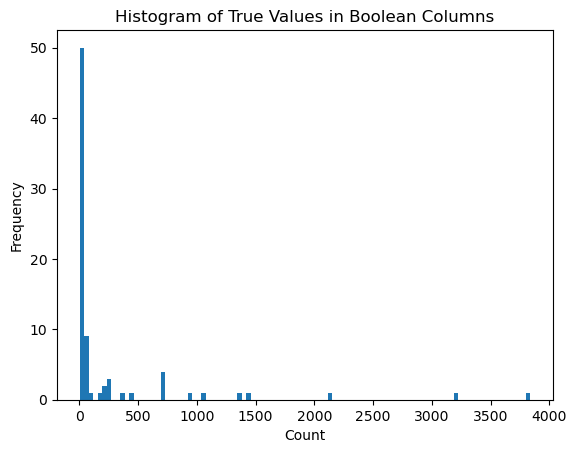

In [46]:
#sum up to see a count of trues for each guilty
true_counts = final.loc[:, 'UNHYGIENIC ACT':'FALSE ALARM'].sum()

# Plot the histogram of true_counts
plt.hist(true_counts, bins=100)

# Set the title and axis labels
plt.title('Histogram of True Values in Boolean Columns')
plt.xlabel('Count')
plt.ylabel('Frequency')

plt.show()

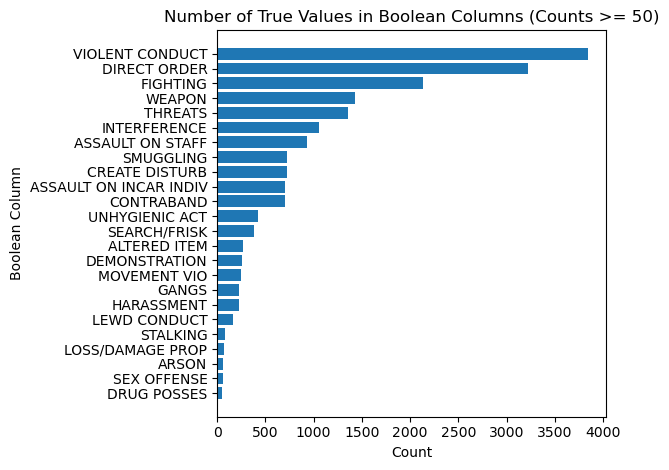

In [47]:
true_counts50 = true_counts[true_counts >= 50]
true_counts50=true_counts50.sort_values()

# Create a horizontal bar chart of the filtered true counts
plt.barh(true_counts50.index, true_counts50.values)

# Set the title and axis labels
plt.title('Number of True Values in Boolean Columns (Counts >= 50)')
plt.ylabel('Boolean Column')
plt.xlabel('Count')

plt.tight_layout()

# Display the chart
plt.show()

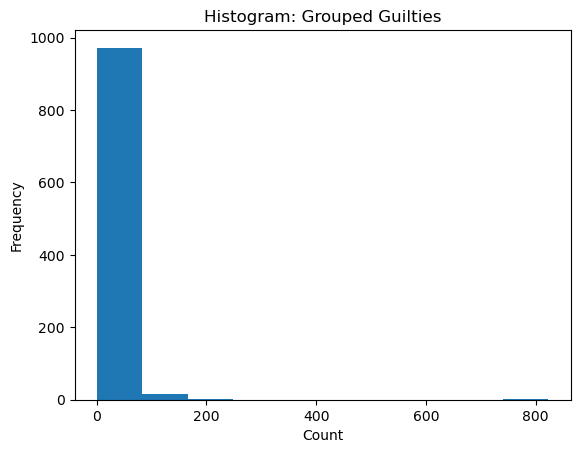

In [146]:
#plot a histogram of the grouped guilties
plt.hist(grouped_final['count'])

# Add title and axis labels
plt.title('Histogram: Grouped Guilties')
plt.xlabel('Count')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

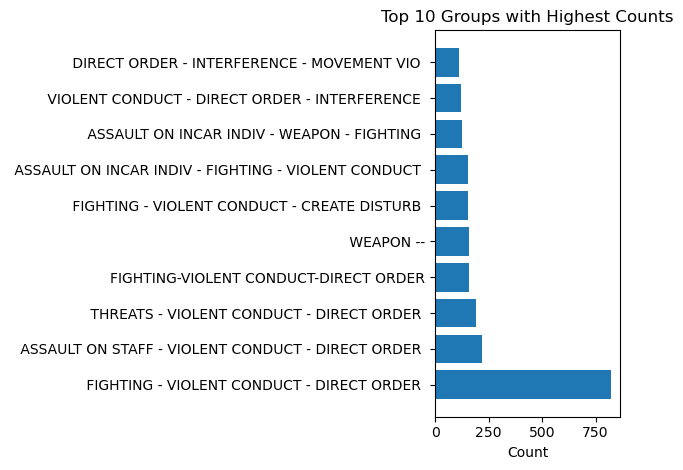

In [147]:
# Get the top 10 groups with the highest counts
top_counts = grouped_final.sort_values('count', ascending=False).head(10)

# Create a horizontal bar chart of the top counts
plt.barh(top_counts['g_label'], top_counts['count'])

# Set the title and axis labels
plt.title('Top 10 Groups with Highest Counts')
plt.xlabel('Count')

plt.tight_layout()

# Display the chart
plt.show()

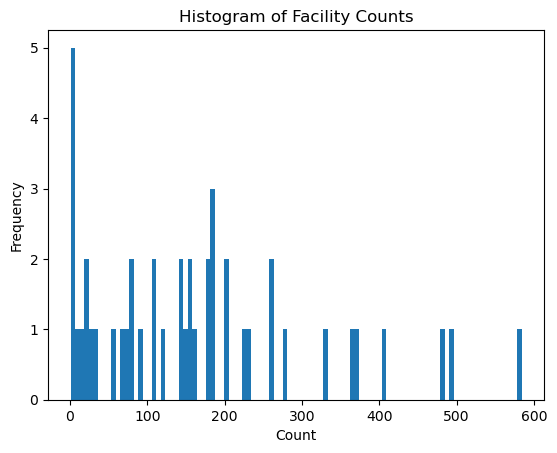

In [148]:

# Group the DataFrame by the "facility" column and count the number of occurrences of each facility
counts = final.groupby("facility").size()

# Plot the histogram of true_counts
plt.hist(counts, bins=100)

# Set the title and axis labels
plt.title('Histogram of Facility Counts')
plt.xlabel('Count')
plt.ylabel('Frequency')

plt.show()

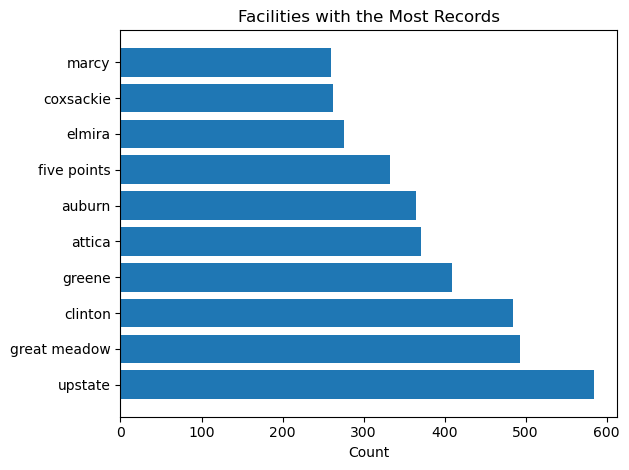

In [149]:
#look at facilities with the most records

mostrecords=final.groupby(['facility']).size().reset_index()
mostrecords.columns=['facility','numrecords']
mostrecords=mostrecords.sort_values(['numrecords'],ascending=False).head(10)

plt.barh(mostrecords['facility'], mostrecords['numrecords'])

# Set the title and axis labels
plt.title('Facilities with the Most Records')
plt.xlabel('Count')

plt.tight_layout()

# Display the chart
plt.show()


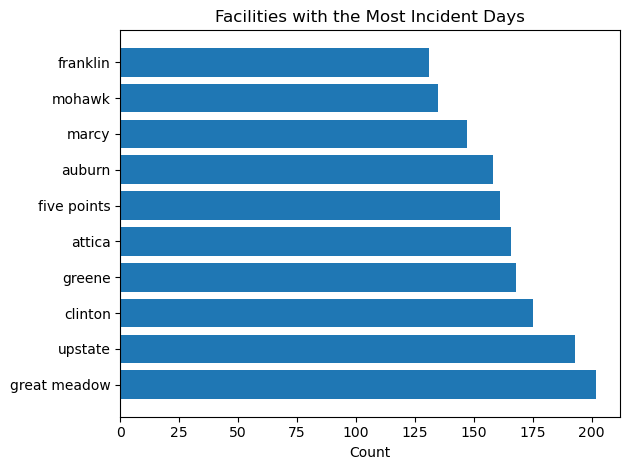

In [150]:
#look at facilities with the most days

incar=final.groupby(['facility','date']).size().reset_index()
incar2=incar.groupby(['facility']).size().reset_index()
incar2.columns=['facility','numdays']
incar2=incar2.sort_values(['numdays'],ascending=False).head(10)

plt.barh(incar2['facility'], incar2['numdays'])

# Set the title and axis labels
plt.title('Facilities with the Most Incident Days')
plt.xlabel('Count')

plt.tight_layout()

# Display the chart
plt.show()


In [151]:
sametimefacilitydate=final.groupby(['facility','date','time','g_label'])['g1'].size().reset_index()
sametimefacilitydate= sametimefacilitydate.sort_values('g1', ascending=False)
sametimefacilitydate.head(10)

,facility,date,time,g_label,g1
5654,upstate,2022-04-19,1107,DEMONSTRATION-DIRECT ORDER-INTERFERENCE,16
5651,upstate,2022-04-19,1105,DEMONSTRATION-DIRECT ORDER-INTERFERENCE,11
1872,coxsackie,2022-08-02,2000,DEMONSTRATION - DIRECT ORDER - UNAUTH ASSMEBLY,9
2177,elmira,2022-10-01,820,FIGHTING - VIOLENT CONDUCT - DIRECT ORDER,9
2899,franklin,2023-01-05,530,THREATS - BRIBERY/EXTORTION - GANGS,9
618,auburn,2022-08-10,743,THREATS - VIOLENT CONDUCT - DEMONSTRATION,8
568,auburn,2022-07-01,2130,DEMONSTRATION - DIRECT ORDER - INTERFERENCE,8
160,attica,2022-05-01,2055,FIGHTING - VIOLENT CONDUCT - DIRECT ORDER,8
2082,elmira,2022-06-04,1522,FIGHTING - VIOLENT CONDUCT - DIRECT ORDER,8
2141,elmira,2022-08-08,1100,ASSAULT ON INCAR INDIV - FIGHTING - VIOLENT C...,8


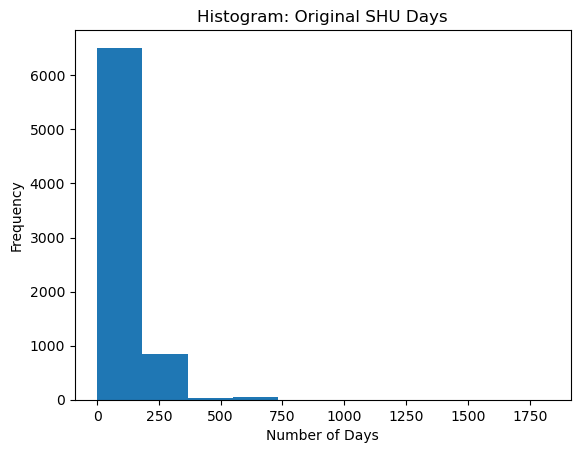

In [152]:
final['orig_shu_days']=final['orig_shu_days'].astype(float)
shu=final['orig_shu_days']
# Plot the histogram of true_counts
plt.hist(shu, bins=10)

# Set the title and axis labels
plt.title('Histogram: Original SHU Days')
plt.xlabel('Number of Days')
plt.ylabel('Frequency')

plt.show()

In [153]:
#look at top shu days

final['orig_shu_days']=final['orig_shu_days'].astype('float')
final[['facility','date','time','orig_shu_days','tot_infractions','tot_g_infractions']].sort_values(['orig_shu_days'],ascending=False).head(20)

,facility,date,time,orig_shu_days,tot_infractions,tot_g_infractions
1064,great meadow,2022-12-15,1300,1825.0,6,5.0
1700,auburn,2022-08-10,743,1441.0,8,7.0
4731,wyoming,2022-07-24,1900,1085.0,4,4.0
1434,coxsackie,2022-08-03,1420,900.0,4,4.0
5402,auburn,2022-05-16,1546,739.0,10,10.0
7431,clinton,2022-04-27,1550,732.0,2,2.0
7213,clinton,2022-04-19,2035,730.0,7,6.0
732,great meadow,2022-12-04,1115,730.0,5,4.0
1747,clinton,2022-08-11,2052,730.0,2,2.0
2454,sullivan,2023-01-12,1355,730.0,3,3.0
